# Dropout
Dropout[1]是一种通过在前向传递过程中随机将一些输出激活设置为零来正则化神经网络的技术。在本练习中，您将实现一个Dropout层，并修改您的全连接网络以选择性地使用Dropout。

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [2]:
!unzip dlcv.zip

Archive:  dlcv.zip
   creating: dlcv/
   creating: dlcv/build/
   creating: dlcv/build/temp.linux-x86_64-3.7/
  inflating: dlcv/build/temp.linux-x86_64-3.7/im2col_cython.o  
   creating: dlcv/classifiers/
  inflating: dlcv/classifiers/cnn.py  
  inflating: dlcv/classifiers/fc_net.py  
  inflating: dlcv/classifiers/k_nearest_neighbor.py  
  inflating: dlcv/classifiers/linear_classifier.py  
  inflating: dlcv/classifiers/linear_svm.py  
  inflating: dlcv/classifiers/softmax.py  
  inflating: dlcv/classifiers/__init__.py  
   creating: dlcv/classifiers/__pycache__/
  inflating: dlcv/classifiers/__pycache__/fc_net.cpython-36.pyc  
  inflating: dlcv/classifiers/__pycache__/fc_net.cpython-37.pyc  
  inflating: dlcv/classifiers/__pycache__/fc_net.cpython-38.pyc  
  inflating: dlcv/classifiers/__pycache__/k_nearest_neighbor.cpython-36.pyc  
  inflating: dlcv/classifiers/__pycache__/k_nearest_neighbor.cpython-37.pyc  
  inflating: dlcv/classifiers/__pycache__/k_nearest_neighbor.cpython-38.pyc  

In [4]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from dlcv.classifiers.fc_net import *
from dlcv.data_utils import get_CIFAR10_data
from dlcv.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from dlcv.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [5]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


In [6]:
test=np.random.rand(4,4)<0.5
print(test)

[[ True  True False  True]
 [False  True False False]
 [ True  True False  True]
 [ True  True False  True]]


# Dropout: Forward Pass
在文件“dlcv / layers.py”,实现dropout的前向传递。由于dropout在训练和测试期间的行为不同，请确保为两种模式实现操作。

完成后，运行下面的单元格来测试你的实现。

In [10]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10
from dlcv.layers import *
for p in [0.25, 0.4, 0.7]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})
    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.29248134569658
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.228024
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  12.066174692541935
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.276056
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  20.559911134743654
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.383312
Fraction of test-time output set to zero:  0.0



# Dropout: Backward Pass
在文件`dlcv/layers.py`中，实现dropout的反向传递。完成之后，运行下面的单元格来进行数值渐变——检查你的实现。

In [13]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less.
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.445612718272284e-11


## Inline Question 1:
如果我们不将通过逆dropout传递的值除以dropout层中的`p`，会发生什么?为什么会这样呢?

## Answer:
[通过Dropout层传递的值除以保留概率p，以补偿Dropout造成的神经元输出的缩放。确保在训练和推断时保持相似的预测行为。如果逆Dropout传递的值不除以Dropout层中保留概率p会导致权重缩放问题，dropout在训练的时候随机失活部分神经元，向前传播被保留的神经元的输出会乘以保留概率p进行缩放。不除以p，保留的神经元的输出值会比期望更大，导致权重的更新过于激烈，可能会影响网络的收敛和训练效果。]


# Fully Connected Networks with Dropout
在文件`dlcv/classifiers/fc_net.py`中，修改你的实现以使用dropout。具体来说，如果网络的构造函数接收到一个不为1的`dropout_keep_ratio`参数值，那么网络应该在每次ReLU非线性之后立即添加一个dropout层。这样做之后,运行以下代码来进行数值梯度——检查你的实现。

In [18]:

np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout_keep_ratio in [1, 0.75, 0.5]:
    print('Running check with dropout = ', dropout_keep_ratio)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        weight_scale=5e-2,
        dtype=np.float64,
        dropout_keep_ratio=dropout_keep_ratio,
        seed=123
    )

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    # Relative errors should be around e-6 or less.
    # Note that it's fine if for dropout_keep_ratio=1 you have W2 error be on the order of e-5.
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print()

Running check with dropout =  1
Initial loss:  2.300479089768492
W1 relative error: 1.03e-07
W2 relative error: 2.21e-05
W3 relative error: 4.56e-07
b1 relative error: 4.66e-09
b2 relative error: 2.09e-09
b3 relative error: 1.69e-10

Running check with dropout =  0.75
Initial loss:  2.3016482157750753
W1 relative error: 3.44e-07
W2 relative error: 5.01e-06
W3 relative error: 1.40e-07
b1 relative error: 1.48e-08
b2 relative error: 9.48e-10
b3 relative error: 1.28e-10

Running check with dropout =  0.5
Initial loss:  2.294963257976082
W1 relative error: 1.20e-07
W2 relative error: 5.54e-07
W3 relative error: 3.75e-07
b1 relative error: 3.35e-09
b2 relative error: 4.40e-09
b3 relative error: 1.44e-10



# Regularization Experiment
作为实验，我们将在500个训练示例上训练一对两层网络:一个将不使用dropout，一个将使用保持概率为0.25。然后，我们将随着时间的推移可视化两个网络的训练和验证精度。

In [21]:
# Train two identical nets, one with dropout and one without.
np.random.seed(231)
num_train = 500
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.5]
for dropout_keep_ratio in dropout_choices:
    model = FullyConnectedNet(
        [500],
        dropout_keep_ratio=dropout_keep_ratio
    )
    print(dropout_keep_ratio)

    solver = Solver(
        model,
        small_data,
        num_epochs=25,
        batch_size=100,
        update_rule='adam',
        optim_config={'learning_rate': 5e-4,},
        verbose=True,
        print_every=100
    )
    solver.train()
    solvers[dropout_keep_ratio] = solver
    print()

1
(Iteration 1 / 125) loss: 7.856642
(Epoch 0 / 25) train acc: 0.260000; val_acc: 0.184000
(Epoch 1 / 25) train acc: 0.416000; val_acc: 0.258000
(Epoch 2 / 25) train acc: 0.482000; val_acc: 0.276000
(Epoch 3 / 25) train acc: 0.532000; val_acc: 0.277000
(Epoch 4 / 25) train acc: 0.600000; val_acc: 0.271000
(Epoch 5 / 25) train acc: 0.708000; val_acc: 0.299000
(Epoch 6 / 25) train acc: 0.722000; val_acc: 0.282000
(Epoch 7 / 25) train acc: 0.832000; val_acc: 0.255000
(Epoch 8 / 25) train acc: 0.878000; val_acc: 0.269000
(Epoch 9 / 25) train acc: 0.902000; val_acc: 0.275000
(Epoch 10 / 25) train acc: 0.888000; val_acc: 0.261000
(Epoch 11 / 25) train acc: 0.926000; val_acc: 0.278000
(Epoch 12 / 25) train acc: 0.960000; val_acc: 0.302000
(Epoch 13 / 25) train acc: 0.964000; val_acc: 0.305000
(Epoch 14 / 25) train acc: 0.966000; val_acc: 0.309000
(Epoch 15 / 25) train acc: 0.976000; val_acc: 0.288000
(Epoch 16 / 25) train acc: 0.988000; val_acc: 0.301000
(Epoch 17 / 25) train acc: 0.988000; v

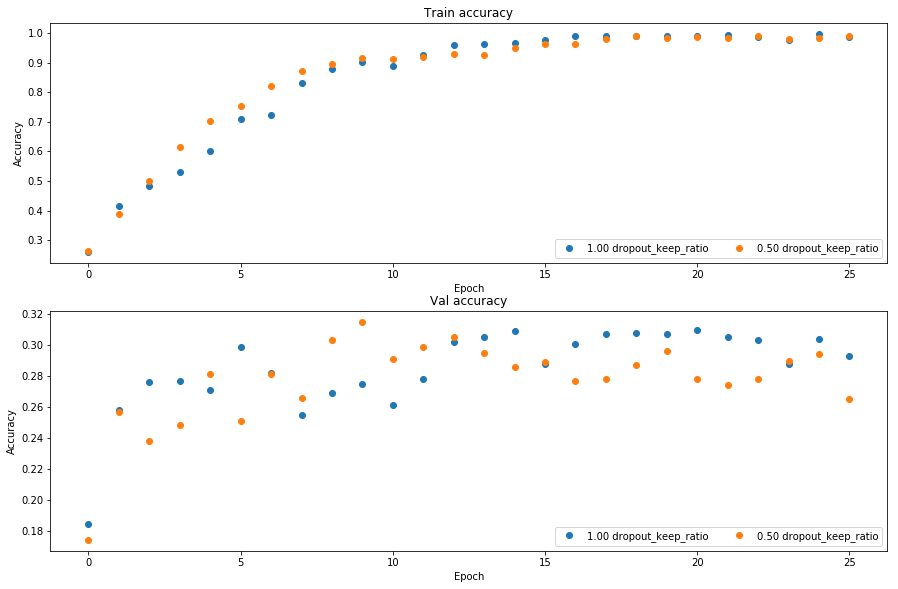

In [22]:
# Plot train and validation accuracies of the two models.
train_accs = []
val_accs = []
for dropout_keep_ratio in dropout_choices:
    solver = solvers[dropout_keep_ratio]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].train_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout_keep_ratio in dropout_choices:
    plt.plot(
        solvers[dropout_keep_ratio].val_acc_history, 'o', label='%.2f dropout_keep_ratio' % dropout_keep_ratio)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:
比较有dropout和没有dropout时的验证精度和训练精度——关于dropout作为正则化器，您的结果表明了什么?

## Answer:

 在没有Dropout的情况下，训练精度往往会高于验证精度，这是由于网络过拟合训练数据。
 但使用Dropout后，训练过程中随机失活神经元，导致模型不能过分依赖某些特定的神经元，因此通常会观察到训练精度和验证精度之间的差距变小。
 Dropout有助于减少过拟合，提高模型的泛化能力。通过在训练期间减少神经元之间的依赖性，模型更可能学习到更加鲁棒和泛化的特征，对未见过的数据表现更好。
 Dropout可以视为在训练期间集成多个子网络的效果，因为每次训练时都会随机丢弃一部分神经元。这有助于模型变得更加稳健，因为它不会过度依赖于单个神经元或特定的路径。


In [26]:
import zipfile
import os

def zip_folder(folder_path, output_path):
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

folder_to_zip = '/path/to/dlcv'  # 修改为要打包的文件夹路径
output_zip = '/path/to/dlcv.zip'  # 修改为要输出的ZIP文件路径

zip_folder(folder_to_zip, output_zip)


/bin/sh: 1: zip: not found
